# Noisy quantum device simulation with QuTiP

Author: Boxi Li (etamin1201@gmail.com)

This is the introduction notebook to the deliverable of one of the Google Summer of Code 2019 project (GSoC2019) "Noise Models in QIP Module", under the organization NumFocus. The final product of the project is a framework of noisy quantum device simulator based on QuTiP open system solvers.

The simulation of quantum information processing is usually achieved by gate matrix product. QuTiP offers this common way of simulation with the class `qutit.qip.QubitCircuit`. It simulates Quantum Information Processing (QIP) in the circuit model.

The simulation introduced here is different as it simulates the dynamics of the qubits at the level of driving Hamiltonian. It is closer to the physical realization than the matrix product and is more convenient when simulating the noise of physical hardware. The simulator is based on QuTiP Lindbladian equation solvers and is defined as `qutip.qip.device.Processor`.

This notebook contains the most essential part of this quantum device simulator, i.e. the noisy evolution under given control pulses. It demonstrates how to setup the parameters and introduce different kinds of noise into the evolution. Gate decomposition for specific hardware realization can be found in the corresponding subclasses. 

## The 3 main ingredients for unitary evolution

### Controlling a single qubit
The simulation of a unitary evolution with `Processor` needs at least 3 ingredients: the control Hamiltonian $H_j$, the pulse intensity $c_j$ and the time $t$. The evolution is given by 

\begin{equation}
U(t)=\exp(-\mathrm{i} \sum_j c_j H_j t)
\end{equation}

The `Processor`, as a simulator of a quantum device, is defined by a list of Hamiltonians, i.e. the control pulse driving the evolution. In this example, we define a single-qubit quantum device with $\sigma_z$ and $\sigma_y$ pulses.

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
pi = np.pi
from qutip.qip.device import Processor, RandomNoise
from qutip import sigmaz, sigmay, sigmax, destroy, basis, fidelity, Bloch
from qutip.qip import rx, ry, rz, hadamard_transform

In [2]:
processor = Processor(N=1)
processor.add_ctrl(sigmaz(), targets=0)
processor.add_ctrl(sigmay(), targets=0)
[ctrl for ctrl in processor.ctrls]

[Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[ 1.  0.]
  [ 0. -1.]],
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[0.+0.j 0.-1.j]
  [0.+1.j 0.+0.j]]]

The pulse intensity and time for each pulse are saved in the attributes `coeffs`, a 2-d NumPy array, and `tlist`, a 1-d NumPy array. `tlist` specifies the start and the end of each pulse, and thus is one element longer than `coeffs`. (This is different from the usual requirement in QuTiP solver where `tlist` and `coeffs` needs to have the same length.) The definition below means that we turn on $\sigma_y$ pulse for $t=\pi$, with intensity 0.5

In [3]:
processor.coeffs = np.array([[ 0. ],
                            [ 0.5]])
processor.tlist = np.array([0., pi])

This pulse is a $\pi$ pulse that flips the qubit from $\left |0 \right\rangle$ to $\left |1 \right\rangle$, equivalent to a rotation around y-axis of angle $\pi$:

$$R_y(\theta) = \begin{pmatrix} cos(\theta/2) & -sin(\theta/2) \\ sin(\theta/2) & cos(\theta/2) \end{pmatrix}$$

We can run the simulation to see the result of the evolution starting from $\left |0 \right\rangle$:

In [4]:
basis0 = basis(2, 0)
result = processor.run_state(rho0=basis0)
result.states[-1]

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-5.68814159e-07]
 [ 1.00000000e+00]]

As arbitrary single-qubit gate can be decomposed into $R_z(\theta_1) \cdot R_y(\theta_2) \cdot R_z(\theta_3)$, it is enough to use three pulses. For demonstration purpose we choose a $\theta_1=\theta_2=\theta_3=\pi/2$

In [5]:
processor.coeffs = np.array([[ 0.5, 0.,  0.5],
                            [ 0. , 0.5, 0. ]])
processor.tlist = np.array([0., pi/2., 2*pi/2, 3*pi/2])

In [6]:
result = processor.run_state(rho0=basis(2, 1))
result.states[-1].tidyup(1.0e-5) 

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-0.7071043+0.j        ]
 [ 0.       +0.70710926j]]

### Pulse with continuous amplitude
If your pulse intensity is generated somewhere else and is a discretization of a continuous function, you can also tell the processor to use them with cubic spline interpolation.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x269995e7748>)

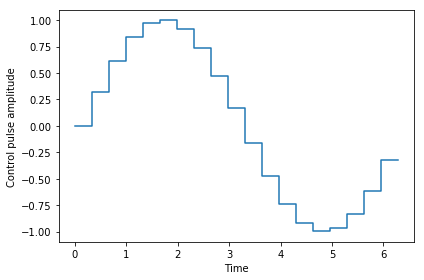

In [7]:
tlist = np.linspace(0., 2*np.pi, 20)
processor = Processor(N=1, spline_kind="step_func")
processor.add_ctrl(sigmaz())
processor.tlist = tlist
processor.coeffs = np.array([[np.sin(t) for t in tlist]])
processor.plot_pulses(noisy=False)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2699989db70>)

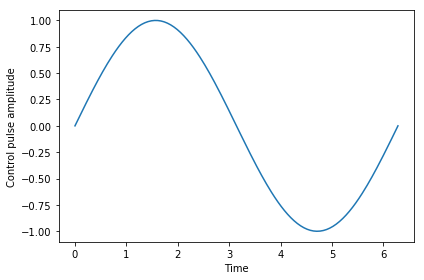

In [8]:
tlist = np.linspace(0., 2*np.pi, 20)
processor = Processor(N=1, spline_kind="cubic")
processor.add_ctrl(sigmaz())
processor.tlist = tlist
processor.coeffs = np.array([[np.sin(t) for t in tlist]])
processor.plot_pulses(noisy=False)

## Noisy evolution

In real quantum devices, noise affects the perfect execution of gate-based quantum circuits, limiting their depths. We can divide quantum noise into two types: coherent and incoherent noise. The former one usually dues to the deviation of the control pulse. The noisy evolution is still unitary. Incoherent noise comes from the coupling of the quantum system with the environment. This type of noise leads to the loss of information. In QIP theory, one describe it with a noisy channel, which correspondes to the collapse operators in the Lindblad equation.

Although noise can be simulated with quantum channel representation, it will need some pre-analysis and approximation, which can be difficult in a large, entangled system. This simulator offers an easier, but computational more demanding solution from the viewpoint of quantum control. `Processor` as a circuit simulator, is different from the common simulator of QIP, as it simulates the evolution of the qubits under the driving Hamiltonian. The noise will be defined according to the control pulses and the evolution will be calculated using QuTiP solvers.

### Decoherence

In `Processor`, decoherence noise is simulated by adding collapse operator into the Lindbladian equation. For single-qubit decoherence, it is equivalent to apply random bit flip and phase flip error after applying the quantum gate. The simulation of decoherence in our model is valid even if the gate time is not much shorter than the decay time, as we don't separate the perfect gate and the noise. For qubit relaxation, one can simply specify the $T_1$ and $T_2$ time for the device or for each qubit. Here we assume the qubit system has a drift Hamiltonian $H_d=\hbar \omega \sigma_z$, for simplicity, we let $\hbar \omega = 10$

In [9]:
a = destroy(2)\dsa
initial_state = basis(2,1)
plus_state = (basis(2,1) + basis(2,0)).unit()
tlist = np.arange(0.00, 2.02, 0.02)
H_d = 10.*sigmaz()

#### Decay time $T_1$
The $T_1$ relaxation time describes the strength of amplitude damping and can be described, in a two-level system, by a collapse operator $\frac{1}{\sqrt{T_1}}a$, where $a$ is the annihilation operator. This leads to an exponential decay of the population of excited states proportional to $\exp({-t/T_1})$. This amplitude damping can be simulated by specifying the attribute `t1` of the processor

In [10]:
t1 = 1.
processor = Processor(1, t1=t1)
processor.tlist = tlist
result = processor.run_state(rho0=initial_state, e_ops=[a.dag()*a])

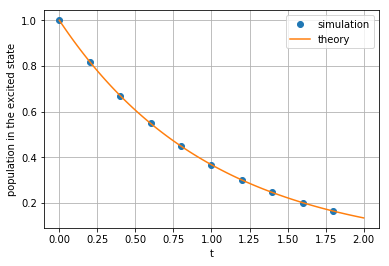

In [11]:
fig, ax = plt.subplots()
ax.plot(tlist[0: 100: 10], result.expect[0][0: 100: 10], 'o', label="simulation")
ax.plot(tlist, np.exp(-1./t1*tlist), label="theory")
ax.set_xlabel("t")
ax.set_ylabel("population in the excited state")
ax.legend()
plt.grid()

#### Decay time $T_2$
The $T_2$ time describes the dephasing process. Here one has to be careful that the amplitude damping channel characterized by $T_1$ will also lead to a dephasing proportional to $\exp(-t/2T_1)$. To make sure that the overall phase dampling is $exp(-t/T_2)$, the processor (internally) uses an collapse operator $\frac{1}{\sqrt{2*T'_2}} \sigma_z$ with $\frac{1}{T'_2}+\frac{1}{2T_1}=\frac{1}{T_2}$ to simulate the dephasing. (This also indicates that $T_2 \leqslant 2T_1$)

Usually, the $T_2$ time is measured by the Ramsey experiment, where the qubit starts from the excited state, undergoes a $\pi/2$ pulse, proceeds for a time $t$, and measured after another $\pi/2$ pulse. For simplicity, here we directly calculate the expectation value of $\rm{H}\circ a^\dagger a \circ\rm{H}$, where $\rm{H}$ denotes the Hadamard transformation. This is equivalent to measure the population of $\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$. The envelope should follow an exponential decay characterized by $T_2$.

In [12]:
t1 = 1. 
t2 = 0.5
processor = Processor(1, t1=t1, t2=t2)
processor.add_ctrl(H_d)
processor.coeffs = np.ones((1,len(tlist)))
processor.tlist= tlist
Hadamard = hadamard_transform(1)
result = processor.run_state(rho0=plus_state, e_ops=[Hadamard*a.dag()*a*Hadamard])

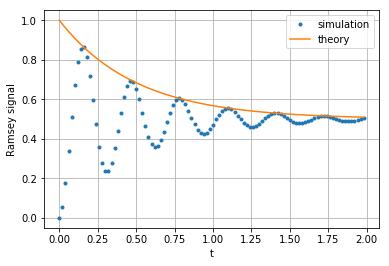

In [13]:
fig, ax = plt.subplots()
# detail about lenght of tlist needs to be fixed
ax.plot(tlist[:-1], result.expect[0][:-1], '.', label="simulation")
ax.plot(tlist[:-1], np.exp(-1./t2*tlist[:-1])*0.5 + 0.5, label="theory")
plt.xlabel("t")
plt.ylabel("Ramsey signal")
plt.legend()
ax.grid()

### Random noise in the pulse intensity

Despite single-qubit decoherence, `Processor` can also simulate coherent  control noise. For general types of noise, one can define a noise object and add it to the processor. An example of predefined noise is the random amplitude noise, where random value is added to the pulse every `dt`. `loc` and `scale` are key word arguments for the random number generator `np.random.normal`.

In [14]:
processor = Processor(N=1)
processor.add_ctrl(sigmaz(), targets=0)
processor.add_ctrl(sigmay(), targets=0)
processor.coeffs = np.array([[ 0.5, 0.,  0.5],
                            [ 0. , 0.5, 0. ]])
processor.tlist = np.array([0., pi/2., 2*pi/2, 3*pi/2])
processor_white = copy.deepcopy(processor)
processor_white.add_noise(RandomNoise(rand_gen=np.random.normal, dt=0.1, loc=-0.05, scale=0.02))  # gausian white noise

We again compare the result of the evolution with and without noise.

In [15]:
result = processor.run_state(rho0=basis(2, 1))
result.states[-1].tidyup(1.0e-5)

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-0.7071043+0.j        ]
 [ 0.       +0.70710926j]]

In [16]:
result_white = processor_white.run_state(rho0=basis(2, 1))
result_white.states[-1].tidyup(1.0e-4)

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-0.56830362-0.02352577j]
 [ 0.24513047+0.78510419j]]

In [17]:
fidelity(result.states[-1], result_white.states[-1])

0.9697483729375561

Since the result of this this noise is still a pure state, we can visualize it on a Bloch sphere

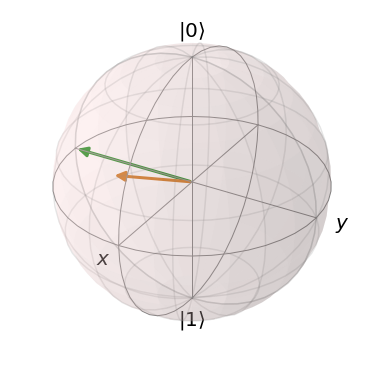

In [18]:
b = Bloch()
b.add_states([result.states[-1], result_white.states[-1]])
b.make_sphere()

The two figures below show the control pulse with and without noise.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2699a135b38>)

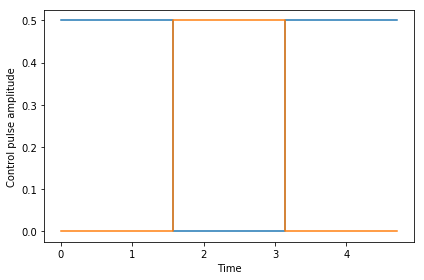

In [19]:
processor_white.plot_pulses(noisy=False)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x269999bb710>)

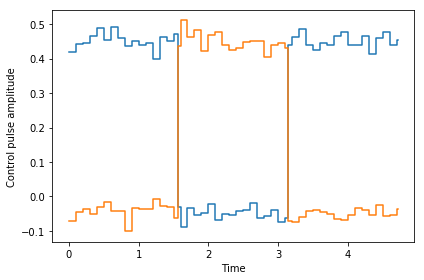

In [20]:
processor_white.plot_pulses(noisy=True)

# Getting the QobjEvo representation
If you define a complicate `Processor` but don't want to run the simulation right now, you can extract a `qutip.QobjEvo` object.

The method `get_unitary_qobjevo` returns the noiseless part of the evolution elements. In contrast, `get_noisy_qobjevo` returns the noisy version, containing the noisy `qutip.QobjEvo` and a list of collapse operators.

In [21]:
qobjevo = processor_white.get_unitary_qobjevo()

In [22]:
qobjevo, cops = processor_white.get_noisy_qobjevo()

(<qutip.qobjevo.QobjEvo at 0x269999cd6a0>, [])

The method `get_noisy_coeffs` will return a list of coefficients and `tlist`. The type of the coefficients depend on the difinition of noise.

In [23]:
coeffs, tlist = processor_white.get_noisy_coeffs()

## Structure inside the simulator

The figures below help one understanding the workflow inside the simulator. The first figure shows how the noise is processed in the circuit processor. The noise is defined separately in a class object. When called, it takes parameters and the unitary noiseless `qutip.QobjEvo` from the processor, generates the noisy version and sends the noisy `qutip.QobjEvo` together with the collapse operators to the processor.

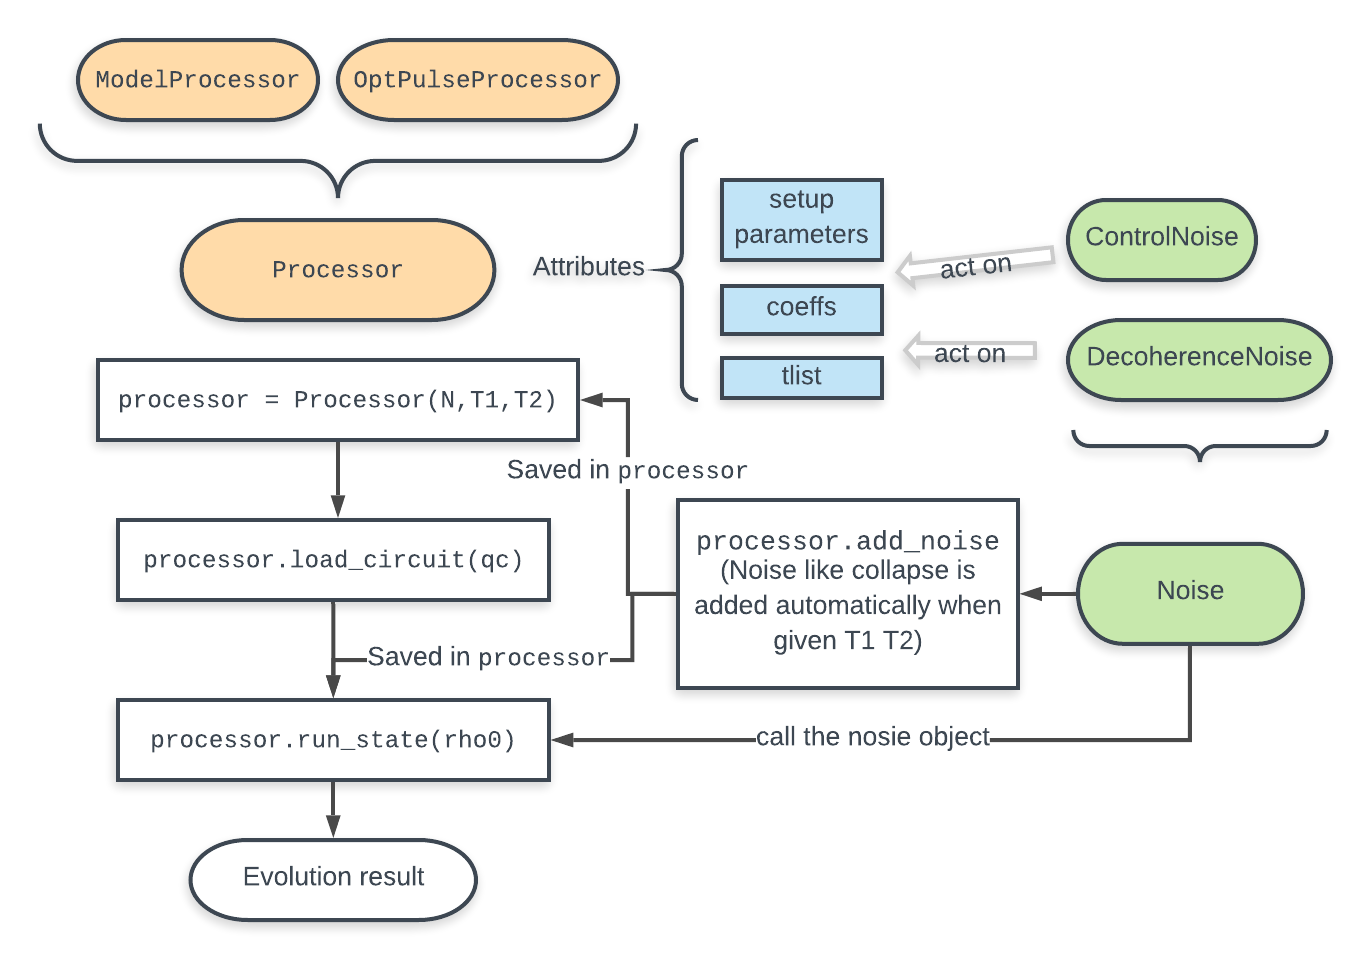

When calculating the evolution, the processor first creates its own `qutip.QobjEvo` of the noiseless evolution. It will then find all the noise objects saved in the attributes `qutip.qip.device.Processor.noise` and call the corresponding methods to get the `qutip.QobjEvo` and a list of collapse operators representing the noise. (For collapse operators, we don't want to add all the consptant collapse into one time-independent operator, so we use a list). The processor then combines its own `qutip.QobjEvo` with those from the noise objects and give them to the solver. The figure below shows how the noiseless part and the noisy part are combined.

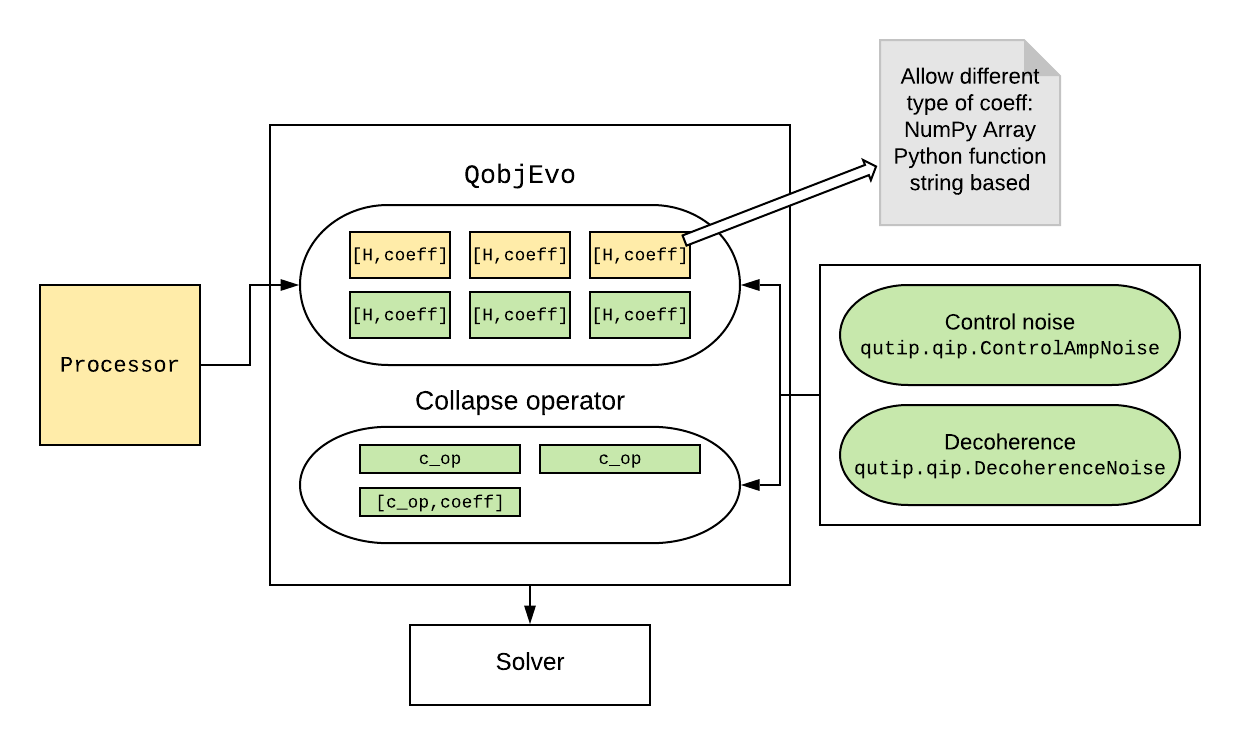

In [24]:
from qutip.ipynbtools import version_table
version_table()

Software,Version
QuTiP,4.5.0.dev0+c50c4bc9
Numpy,1.16.2
SciPy,1.2.1
matplotlib,3.0.3
Cython,0.29.12
Number of CPUs,12
BLAS Info,INTEL MKL
IPython,7.4.0
Python,"3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]"
OS,nt [win32]
